# PyTorch를 활용한 이미지 분류 모델의 훈련

## CNN의 기본 원리

이미지 분류는 입력 이미지가 어떤 카테고리에 속하는지 예측하는 작업입니다.

현대적인 이미지 분류 모델들은 주로 합성곱 신경망(CNN, Convolutional Neural Network) 구조를 사용합니다.

CNN은 이미지의 공간적 구조를 활용하기 위해 **합성곱 계층(convolution layer)**을 사용하는 신경망입니다.

합성곱 계층에서는 이미지에 작은 **필터(kernel)**를 슬라이딩하며 적용하여 **특징 맵(feature map)**을 추출합니다.

초기 계층들은 **에지(edge)**나 색상 대비 등의 저수준 특징을 감지하고, 심층 계층으로 갈수록 **모양(shape)**이나 패턴(pattern) 같은 고수준 특징을 학습합니다.

이런 방식으로 CNN은 국소적 연결과 가중치 공유를 통해 파라미터 수를 줄이고, 이미지의 **평행 이동 불변성(translation invariance)**을 어느 정도 확보합니다.

또한 풀링(pooling) 계층을 사용하여 특징 맵의 크기를 줄이고 중요한 특징을 강조함으로써 모델의 불변성과 일반화 성능을 높입니다.

## Nvidia-GPU 설정 여부 확인

In [2]:
!nvidia-smi

Tue May  6 06:59:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## CIFAR-10 데이터셋을 이용한 간단한 이미지 분류

[CIFAR-10 데이터셋](https://www.cs.toronto.edu/~kriz/cifar.html)은 10개의 카테고리로 이루어진 작은 컬러 이미지(32×32 픽셀) 데이터셋입니다.

실습에서는 간단한 CNN 분류기를 만들어 훈련시키고, 모델의 성능을 평가해보겠습니다.

### 데이터셋 설정

먼저 CIFAR-10 데이터셋을 불러오고 전처리합니다.

PyTorch의 torchvision.datasets 모듈을 사용하면 CIFAR-10 데이터를 쉽게 가져올 수 있습니다.

Colab 환경에서는 download=True로 설정하면 인터넷에서 자동으로 데이터를 다운로드합니다.

각 이미지는 [0,1] 범위로 정규화하기 위해 ToTensor 변환만 적용합니다.

데이터로더(DataLoader)를 이용하여 배치 단위로 데이터를 불러올 수 있습니다.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# 하이퍼파라미터 설정
batch_size = 64

# CIFAR-10 데이터셋 로드 (train과 test)
transform = transforms.ToTensor()  # 이미지를 tensor로 변환 (0~1 스케일)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# DataLoader를 통해 배치 구성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

print(f"훈련 데이터 개수: {len(train_dataset)}, 테스트 데이터 개수: {len(test_dataset)}")

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


훈련 데이터 개수: 50000, 테스트 데이터 개수: 10000


위 코드는 CIFAR-10 훈련용 이미지 50,000장과 테스트용 10,000장을 로드합니다.

train_loader를 통해 매 iteration마다 64개 이미지 배치와 레이블(label)을 불러올 수 있습니다.

각 레이블은 0~9 정수로 나타내며, 10개의 카테고리를 의미합니다.

### 이미지 분류 모델 구현

다음으로 간단한 CNN 모델을 정의합니다.

여기서는 3개의 합성곱 층과 1개의 완전연결 층으로 구성된 작은 네트워크를 사용합니다.

활성화 함수로 ReLU를 사용하고, 합성곱 층 뒤에 풀링을 넣어 특징맵 크기를 줄입니다.

마지막으로 10개의 출력 뉴런을 사용하여 CIFAR-10의 10개 클래스를 예측합니다.

모델 구현은 nn.Module을 상속한 Python 클래스 형태로 작성하며, forward 메서드에서 입력 x가 거치는 연산을 차례로 정의합니다.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 합성곱층 정의: 입력 채널 3개(RGB), 출력 채널 16개, 커널 크기 3
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 풀링 (이미지 크기 절반 축소)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 완전연결층: 최종 특징맵을 펼쳐서 64*4*4 차원을 입력으로 받아 10차원 출력
        self.fc = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        # 합성곱 -> ReLU -> 풀링 순차 적용 (3회)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # 특징맵을 일렬로 펼치기 (배치 크기는 유지하고 나머지 차원을 flatten)
        x = x.view(x.size(0), -1)
        # 완전연결층을 거쳐 10차원 출력 (클래스별 logit)
        x = self.fc(x)
        return x

모델은 32x32 입력을 받아 conv1~conv3을 통과하면서 점차 채널은 늘어나고 공간 크기는 1/8로 줄어듦

마지막으로 fc 층이 10차원 출력을 내며, 이는 각 클래스에 대한 점수(score)로 이해할 수 있음

### 훈련을 위한 하이퍼파라미터 설정

In [5]:
# 모델 및 손실함수, 최적화기 설정
Lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)  # GPU 사용 가능하면 GPU로 이동
criterion = nn.CrossEntropyLoss()  # 분류 문제이므로 교차 엔트로피 손실
optimizer = torch.optim.Adam(model.parameters(), lr=Lr)

max_epochs = 5  # 간단히 5 epoch만 수행 (필요시 늘릴 수 있음)

손실 함수는 분류에 흔히 쓰이는 **교차 엔트로피(CrossEntropy)**를 사용함

최적화 알고리즘은 Adam으로 설정하였으며, 학습률은 0.001을 사용함

만약 GPU를 사용할 수 있다면, model.to(device)와 같이 모델을 GPU로 보내고, 이후 텐서들도 .to(device)로 GPU에 올려서 연산하면 학습이 훨씬 빠름

훈련은 총 5번의 epoch동안 수행하도록 함

### 훈련

이제 모델을 CIFAR-10 훈련 데이터에 맞춰 학습시킵니다.

일반적인 PyTorch 학습 루프 구성은 다음과 같습니다.

- 모델을 훈련 모드로 설정 (model.train()).

- 데이터로더를 순회하면서 배치를 불러옴.

- 입력과 레이블을 받아 모델의 forward를 통해 예측값을 계산.

- 예측값과 정답 레이블을 가지고 손실 함수를 계산.

- optimizer.zero_grad()로 이전 배치의 그라디언트 초기화.

- loss.backward()로 손실에 대한 그래디언트를 계산 (자동 미분).

- optimizer.step()으로 파라미터 업데이트.

에포크(epoch)는 훈련 데이터를 한 번 모두 돌았을 때를 말하며, 여러 epoch 동안 위 과정을 반복하면서 모델이 점진적으로 학습됩니다.

더 많은 epoch를 돌리면 성능이 향상되지만, 시간 관계상 일단 5 epoch로 제한합니다.

In [7]:
model.train()   # 모델을 학습 모드로 설정

for epoch in range(1, max_epochs+1):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 순전파: 모델 예측 실행
        outputs = model(images)
        loss = criterion(outputs, labels)
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 한 epoch 종료 - 평균 손실 출력
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch}] 평균 훈련 손실: {avg_loss:.4f}")

[Epoch 1] 평균 훈련 손실: 1.6056
[Epoch 2] 평균 훈련 손실: 1.2817
[Epoch 3] 평균 훈련 손실: 1.1323
[Epoch 4] 평균 훈련 손실: 1.0387
[Epoch 5] 평균 훈련 손실: 0.9601


running_loss를 통해 epoch당 손실의 추이를 추적하고 출력합니다.

학습 도중 출력되는 손실값이 점차 감소하는 것을 볼 수 있을 것입니다.

손실이 내려간다는 것은 모델의 예측이 정답에 가까워지고 있음을 의미합니다.

### 모델 평가

모델 학습이 끝나면 테스트 데이터로 성능을 평가해보겠습니다.

분류 모델의 대표적인 성능 지표는 **정확도(accuracy)**입니다.

테스트 집합의 이미지들에 대해 모델이 얼마나 정답 레이블을 맞추는지 계산해봅니다.

In [8]:
model.eval()  # 평가 모드 (배치정규화나 드롭아웃 비활성화)
correct = 0
total = 0
with torch.no_grad():  # 평가 시 그래디언트 계산 비활성화 (메모리/속도 절약)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)               # forward 실행
        _, predicted = torch.max(outputs, 1)  # 가장 높은 점수의 클래스를 예측 결과로 선정
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")

테스트 정확도: 66.25%


위 코드에서는 테스트 데이터 10,000개 전체에 대한 예측을 수행하고 정확도를 계산합니다.

"테스트 정확도: 55.30%"와 같이 출력될 것입니다.

간단한 모델이라 높은 정확도는 아니지만, 학습을 더 진행하거나 모델 구조를 개선하면 향상시킬 수 있습니다.

### 추론 결과 시각화

이제 임의의 테스트 이미지 몇 장을 직접 확인해보겠습니다.

 이미지와 함께 모델의 예측 라벨과 실제 라벨을 출력해봅니다.

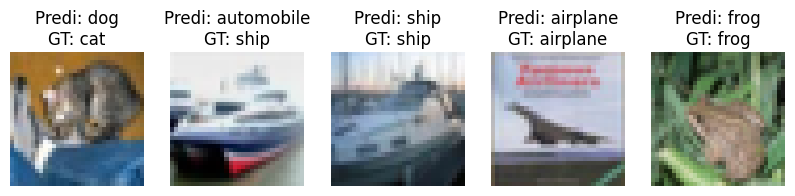

In [11]:
# 테스트 데이터 일부 시각화
import matplotlib.pyplot as plt

classes = train_dataset.classes  # CIFAR-10 클래스 이름들 리스트

dataiter = iter(test_loader)
images, labels = next(dataiter)  # 배치에서 첫 몇 개 이미지 가져오기
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# CPU로 가져와서 numpy로 변환 (이미지 표시 위해)
images = images.cpu().numpy()
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()

# 처음 5개 이미지의 예측 결과를 시각화
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].transpose((1, 2, 0))  # (채널,세로,가로) -> (세로,가로,채널)
    plt.imshow(img)
    plt.title(f"Predi: {classes[preds[i]]}\nGT: {classes[labels[i]]}")
    plt.axis('off')
plt.show()

위 코드는 테스트 배치에서 다섯 장의 이미지를 가져와, 모델의 예측과 정답을 비교하여 보여줍니다.

classes는 CIFAR-10의 클래스 이름 리스트이며 (예: ['airplane', 'automobile', 'bird', ...]), 예측 결과와 실제 레이블을 한글 타이틀로 표시합니다.

예측이 맞았는지/틀렸는지를 이미지로 확인하면서 모델의 성능을 직관적으로 파악할 수 있습니다.

## 실습 과제

### 실습 1

위에서 정의한 SimpleCNN보다 더 깊거나 폭이 넓은 모델을 구성해보고 정확도 변화를 관찰해보세요 (예: 합성곱 층 개수 증가, 채널 수 증가 등).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# CNN 모델 정의
class NewCMNN(nn.Module):
    def __init__(self):
        super(self).__init__()

    def forward(self, x):
        return x

In [ ]:
# 모델 및 손실함수, 최적화기 설정
Lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NewCMNN().to(device)  # GPU 사용 가능하면 GPU로 이동
criterion = nn.CrossEntropyLoss()  # 분류 문제이므로 교차 엔트로피 손실
optimizer = torch.optim.Adam(model.parameters(), lr=Lr)

max_epochs = 5  # 간단히 5 epoch만 수행 (필요시 늘릴 수 있음)

model.train()   # 모델을 학습 모드로 설정

for epoch in range(1, max_epochs+1):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 순전파: 모델 예측 실행
        outputs = model(images)
        loss = criterion(outputs, labels)
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 한 epoch 종료 - 평균 손실 출력
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch}] 평균 훈련 손실: {avg_loss:.4f}")

model.eval()  # 평가 모드 (배치정규화나 드롭아웃 비활성화)
correct = 0
total = 0
with torch.no_grad():  # 평가 시 그래디언트 계산 비활성화 (메모리/속도 절약)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)               # forward 실행
        _, predicted = torch.max(outputs, 1)  # 가장 높은 점수의 클래스를 예측 결과로 선정
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")

### 실습 2

Optimizer나 학습률을 바꿔 실험해보세요.

SGD와 Adam을 비교하거나 학습률을 높여/낮춰 보면서 학습 속도와 정확도에 미치는 영향을 확인합니다.

[PyTorch Optimizer](https://pytorch.org/docs/main/optim.html)

In [ ]:
Lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=Lr)

In [ ]:
# 모델 및 손실함수 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NewCMNN().to(device)  # GPU 사용 가능하면 GPU로 이동
criterion = nn.CrossEntropyLoss()  # 분류 문제이므로 교차 엔트로피 손실

max_epochs = 5  # 간단히 5 epoch만 수행 (필요시 늘릴 수 있음)

model.train()   # 모델을 학습 모드로 설정

for epoch in range(1, max_epochs+1):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 순전파: 모델 예측 실행
        outputs = model(images)
        loss = criterion(outputs, labels)
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 한 epoch 종료 - 평균 손실 출력
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch}] 평균 훈련 손실: {avg_loss:.4f}")

model.eval()  # 평가 모드 (배치정규화나 드롭아웃 비활성화)
correct = 0
total = 0
with torch.no_grad():  # 평가 시 그래디언트 계산 비활성화 (메모리/속도 절약)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)               # forward 실행
        _, predicted = torch.max(outputs, 1)  # 가장 높은 점수의 클래스를 예측 결과로 선정
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")

### 실습 3

데이터 증가(Data Augmentation) 기법을 적용해보세요.

예를 들어 transforms.RandomHorizontalFlip() 등을 transform에 추가하여 훈련 이미지에 무작위 좌우반전 등을 적용하면 성능 향상에 도움이 될 수 있습니다.

[Torchvision transforms](https://pytorch.org/vision/0.9/transforms.html)

In [ ]:
transform = transforms.Compose([

])

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 하이퍼파라미터 설정
batch_size = 64

# CIFAR-10 데이터셋 로드 (train과 test)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# DataLoader를 통해 배치 구성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

print(f"훈련 데이터 개수: {len(train_dataset)}, 테스트 데이터 개수: {len(test_dataset)}")

# 모델 및 손실함수, 최적화기 설정
Lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NewCMNN().to(device)  # GPU 사용 가능하면 GPU로 이동
criterion = nn.CrossEntropyLoss()  # 분류 문제이므로 교차 엔트로피 손실
optimizer = torch.optim.Adam(model.parameters(), lr=Lr)

max_epochs = 5  # 간단히 5 epoch만 수행 (필요시 늘릴 수 있음)

model.train()   # 모델을 학습 모드로 설정

for epoch in range(1, max_epochs+1):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 순전파: 모델 예측 실행
        outputs = model(images)
        loss = criterion(outputs, labels)
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 한 epoch 종료 - 평균 손실 출력
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch}] 평균 훈련 손실: {avg_loss:.4f}")

model.eval()  # 평가 모드 (배치정규화나 드롭아웃 비활성화)
correct = 0
total = 0
with torch.no_grad():  # 평가 시 그래디언트 계산 비활성화 (메모리/속도 절약)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)               # forward 실행
        _, predicted = torch.max(outputs, 1)  # 가장 높은 점수의 클래스를 예측 결과로 선정
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")